In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import gsw as sw
from typing import Tuple


# Path containing python functions
path = ['/Users/research/Documents/GitHub/gliderProcessing/glider_processing_scripts/']

sys.path.append(path[0])
from functions import c2salinity, stp2ct_density, p2depth, dm2d, O2freshtosal

# Explore Glider Processing Steps

A notebook to test functions and get comfortable with the toolbox capabilities
- Do some basic processing
- Plot some things
- Showcase functions and capabilities

### Checking out the dead reckoning correction for Slocum glider based on `x_dr_state`

In [2]:
# Glider data set from Unit 334 collected in Placentia Bay in 2022
df = pd.read_csv('glider_334_data.csv')
# convert from DDMM.MM to DD.DD
for col in ['lat', 'lon', 'gps_lat', 'gps_lon']:
    if(col in df.keys()):
        df[col] = dm2d(df[col])

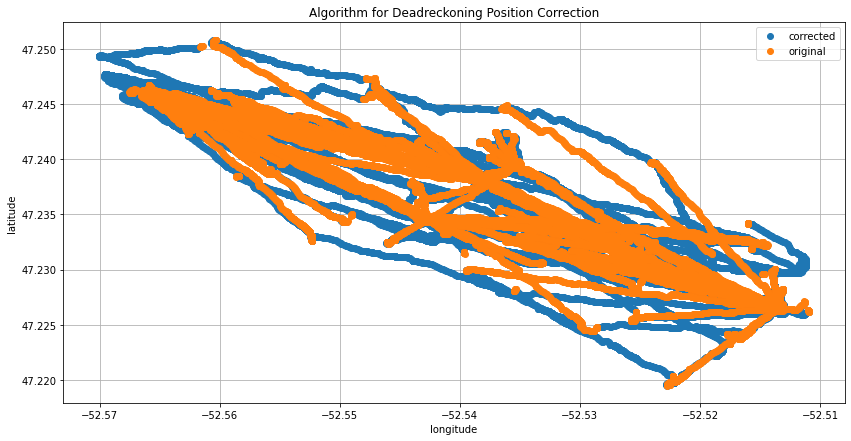

In [3]:
# Run the dead reckoning correction code
from functions import correct_dead_reckoning
df['lon_corrected'],df['lat_corrected'] = correct_dead_reckoning(df['lon'],df['lat'],df['time'],df['dr_state'],df['gps_lon'],df['gps_lat'])

fig, ax = plt.subplots(figsize=(14,7))
ax.plot(df['lon_corrected'],df['lat_corrected'],'o',label='corrected')
ax.plot(df['lon'],df['lat'],'o',label='original')
ax.set(xlabel='longitude', ylabel='latitude',
       title='Algorithm for Deadreckoning Position Correction')
ax.grid()
ax.legend()
fig.savefig("DRtest.png")
plt.show()


### Split Profiles
The findProfiles function splits the glider depth,time data to profiles and profile direction, which is useful for further post-processing

In [4]:
# initialize test data
#depth = np.array([0.5,0.7,1,2,3,4,5,6,7,8,9,10,9,10,9,8,7,6,5,4,3,2,1.5,0.9,0])
#stamp = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

# Interpolate and fill gaps linearly but preserving nans in the beginning and end (crude method to get what we want)
#df = df.fillna(method='ffill') + (df.fillna(method='bfill') * 0)
df['depth'] = p2depth(df['ctd_pressure'].to_numpy()*10)

from functions import findProfiles
df['profile_index'],df['profile_direction']=findProfiles(df['time'].to_numpy(),df['depth'].to_numpy(),stall=20,shake=200)




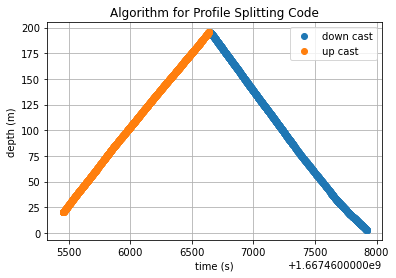

In [5]:

fig, ax = plt.subplots()
idx_down = np.flatnonzero(df['profile_index'] == 120)
idx_up = np.flatnonzero(df['profile_index'] == 119)

ax.plot(df['time'].values[idx_down], df['depth'].values[idx_down], 'o', label='down cast')
ax.plot(df['time'].values[idx_up], df['depth'].values[idx_up], 'o', label='up cast')
ax.set(xlabel='time (s)', ylabel='depth (m)',
       title='Algorithm for Profile Splitting Code')
ax.grid()
ax.legend()
plt.show()
